# BEE 4750 Homework 2: Systems Modeling and Simulation

**Name**:

**ID**:

> **Due Date**
>
> Thursday, 09/19/24, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to derive a model for water quality in a river
    system and use this model to check for regulatory compliance.
-   Problem 2 asks you to explore the dynamics and equilibrium stability
    of the shallow lake model under a particular set of parameter
    values.
-   Problem 3 (5750 only) asks you to modify the lake eutrophication
    example from Lecture 04 to account for atmospheric deposition.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Desktop/Julia Scripts/HW2-ReidHarwell/hw2-rmh254`
   Installed JpegTurbo_jll ─────── v2.1.91+0
   Installed Preferences ───────── v1.4.0
   Installed LoggingExtras ─────── v1.0.0
   Installed RelocatableFolders ── v1.0.0
   Installed Accessors ─────────── v0.1.37
   Installed GR_jll ────────────── v0.72.7+0
   Installed Unitful ───────────── v1.14.0
   Installed InlineStrings ─────── v1.4.0
   Installed ConcurrentUtilities ─ v2.2.0
   Installed PlotUtils ─────────── v1.3.5
   Installed InvertedIndices ───── v1.3.0
   Installed Roots ─────────────── v2.1.6
   Installed ColorSchemes ──────── v3.21.0
   Installed OpenSSL ───────────── v1.4.1
   Installed Missings ──────────── v1.1.0
   Installed Qt5Base_jll ───────── v5.15.3+2
   Installed SentinelArrays ────── v1.4.3
   Installed DataFrames ────────── v1.6.1
   Installed SpecialFunctions ──── v2.3.0
   Installed HTTP ──────────────── v1.9.7
   Installed WorkerUtilities ───── v1.6.1
   Installed TranscodingStrea

In [2]:
using Plots
using LaTeXStrings
using CSV
using DataFrames
using Roots

## Problems (Total: 50/60 Points)

### Problem 1 (25 points)

A river which flows at 10 km/d is receiving discharges of wastewater
contaminated with CRUD from two sources which are 15 km apart, as shown
in the Figure below. CRUD decays exponentially in the river at a rate of
0.36 $\mathrm{d}^{-1}$.

<figure>
<img src="attachment:figures/river_diagram.png"
alt="Schematic of the river system in Problem 1" />
<figcaption aria-hidden="true">Schematic of the river system in Problem
1</figcaption>
</figure>

**In this problem**:

-   Assuming steady-state conditions, derive a model for the
    concentration of CRUD downriver by solving the appropriate
    differential equation(s) analytically.
-   Determine if the system in compliance with a regulatory limit of 2.5
    kg/(1000 m$^3$).

In [29]:
function CRUD_simulate(C0, V0, C1, V1, C2, V2, U, d, X, Δx)
    steps = Int64(X / Δx)   #establish length based on furthest downstream you want to measure X 
    C = zeros(steps + 1)    #initiate array C of length steps + 1
    C[1] = C0               #set initial condition to first input C0 
    X2 = 15/Δx              #set point where second input joins stream at 15 km 
    for x = 1 : X2          #establishes values where there is only one input 
        C[x+1] = ((C0 * V0 + C1 * V1)/(V1+V2))*(1-d)^(x/U) 
    end
    for x=(X2-1):steps          #establishes values at and after the second input stream 
        C[x+1] = (((C[X2]*(V0+V1)*(1-d)^(15/U))+C2*V2)/(V0+V1+V2))*(1-d)^((x+1-15)/U)
    end
    return C
end

C0 = 0.5
V0 = 250
C1 = 9
V1 = 40
C2 = 7
V2 = 60
U = 10
d = 0.36
X = 16
Δx = 0.5

CRUD = CRUD_simulate(C0, V0, C1, V1, C2, V2, U, d, X, Δx)
plot(0:X, CRUD)
plot!( xlabel = "Distance from Input 1", ylabel="Concentration of CRUD (kg/m^3)")

ArgumentError: ArgumentError: invalid index: 2.0 of type Float64

> **Tip**
>
> Formulate your model in terms of distance downriver, rather than
> leaving it in terms of time from discharge.

### Problem 2 (25 points)

Consider the shallow lake model from class:

$$
\begin{aligned}
X_{t+1} &= X_t + a_t + y_t + \frac{X_t^q}{1 + X_t^q} - bX_t, \\
y_t &\sim \text{LogNormal}(\mu, \sigma^2),
\end{aligned}
$$

where:

-   $X_t$ is the lake phosphorous (P) concentration at time $t$;
-   $a_t$ is the point-source P release at time $t$;
-   $y_t$ is the non-point-source P release at time $t$, which is
    treated as random from a LogNormal distribution with mean $\mu$ and
    standard deviation $\sigma$;
-   $b$ is the linear rate of P outflow;
-   $q$ is a parameter influencing the rate of P recycling from the
    sediment.

**In this problem**:

-   Make an initial conditions plot for the model dynamics for $b=0.5$,
    $q=1.5$, $y_t=0$, and $a_t=0$ for $t=0, \ldots, 30$. What are the
    equilibria? What can you say about the resilience of the system?

    > **Finding equilibria**
    >
    > Use [`Roots.jl`](https://juliamath.github.io/Roots.jl/stable/) to
    > find the equilibria by solving for values where $X_{t+1} = X_t$.
    > For example, if you have functions `X_outflow(X,b)` and
    > `X_recycling(X,q)`, you could create a function
    > `X_delta(x, a) = a + X_recycling(x) - X_outflow(x)` and call
    > `Roots.find_zero(x -> X_delta(x, a), x₀)`, where `x₀` is an
    > initial value for the search (you might need to use your plot to
    > find values for `x₀` near each of the “true” equilibria).

-   Repeat the analysis with $a_t=0.02$ for all $t$. What are the new
    equilibria? How have the dynamics and resilience of the system
    changed?

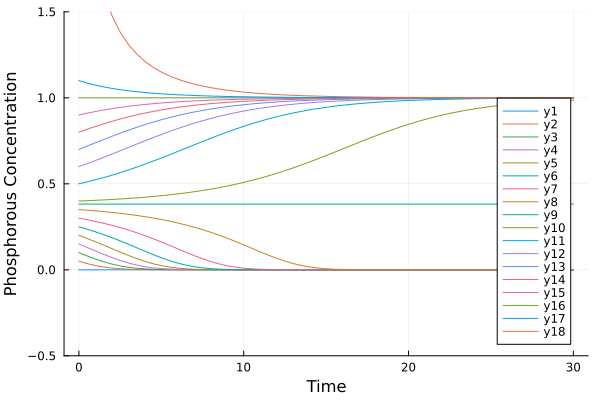

In [98]:
function lake_phos_step(C, a, y, q, b)
    return (a + y + (C^q)/(1+C^q) - b*C)
end

# this function loops over the timesteps to simulate
# the concentration series
function phosphorous_simulate(C0, a, y, q, b, T, Δt)
    steps = Int64(T / Δt)
    C = zeros(steps + 1)
    C[1] = C0
    for t = 1:steps
        C[t+1] = C[t] + 
            lake_phos_step(C[t], a, y, q, b)
    end
    # the first element of C is the initial condition
    return C
end

C0 = (0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.381966, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1)
a = 0
y = 0
b = 0.5
q = 1.5
T = 30
Δt = 0.5
B = Int64(T/Δt +1)
C = phosphorous_simulate(C0[1], a, y, q, b, T, Δt)

r = range(0, T, B)
#s = phosphorous_simulate(C0, a, y, q, b, T, Δt)
plot(r, C)
plot!(xlabel="Time", ylabel="Phosphorous Concentration")
plot!(ylimits=(-0.5,1.5))
plot!(r, phosphorous_simulate(C0[2], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[3], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[4], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[5], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[6], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[7], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[8], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[9], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[10], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[11], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[12], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[13], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[14], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[15], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[16], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[17], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(2.61, a, y, q, b, T, Δt) )



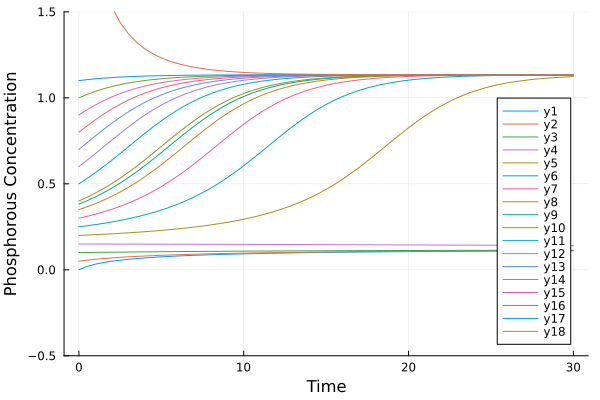

In [99]:
function lake_phos_step(C, a, y, q, b)
    return (a + y + (C^q)/(1+C^q) - b*C)
end

# this function loops over the timesteps to simulate
# the concentration series
function phosphorous_simulate(C0, a, y, q, b, T, Δt)
    steps = Int64(T / Δt)
    C = zeros(steps + 1)
    C[1] = C0
    for t = 1:steps
        C[t+1] = C[t] + 
            lake_phos_step(C[t], a, y, q, b)
    end
    # the first element of C is the initial condition
    return C
end

C0 = (0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.381966, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1)
a = 0.02
y = 0
b = 0.5
q = 1.5
T = 30
Δt = 0.5
B = Int64(T/Δt +1)
C = phosphorous_simulate(C0[1], a, y, q, b, T, Δt)

r = range(0, T, B)
plot(r, C)
plot!(xlabel="Time", ylabel="Phosphorous Concentration")
plot!(ylimits=(-0.5,1.5))
plot!(r, phosphorous_simulate(C0[2], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[3], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[4], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[5], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[6], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[7], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[8], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[9], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[10], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[11], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[12], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[13], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[14], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[15], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[16], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(C0[17], a, y, q, b, T, Δt) )
plot!(r, phosphorous_simulate(2.61, a, y, q, b, T, Δt) )

### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

Consider the lake eutrophication example from [Lecture
04](https://viveks.me/environmental-systems-analysis/slides/lecture03-1-eutrophication-modeling.html#/title-slide).
Suppose that phosphorous is also atmospherically deposited onto the lake
surface at a rate of
$1.6 \times 10^{-4} \mathrm{kg/(yr} \cdot \mathrm{m}^2)$, which is then
instantly mixed into the lake. Derive a model for the lake phosphorous
concentration and find the maximum allowable point source phosphorous
loading if the goal is to keep lake concentrations below 0.02 mg/L.

## References

List any external references consulted, including classmates.